# **Data Generation**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras import models, Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
tf.logging.set_verbosity(tf.logging.ERROR)

NOTE_MIN = 53
NOTE_MAX = 93
DOWNLOAD = True

In [0]:
dropbox_link = "https://www.dropbox.com/s/72b7bsjxbe3ibxc/June_Fixes_Notes.npy?dl=0"
if DOWNLOAD or datafile is None:
  dropbox_link = dropbox_link.replace("www.dropbox.com", "dl.dropboxusercontent.com", 1)
  import requests, zipfile, io, os
  r = requests.get(dropbox_link)
  datafile = io.BytesIO(r.content)
  print("Download complete")
raw_data = np.load(datafile, allow_pickle=True)

Download complete


In [0]:
folkrnn = np.load('./folkRnn_data.npy', allow_pickle=True)
folk = []

tunes_generated = np.load('./generated_data.npy', allow_pickle=True)
tunes_generated = tunes_generated.reshape(820,4,64)

magenta_generated = np.load('./magenta_generated.npy', allow_pickle=True)
magenta_generated = magenta_generated.reshape(820,4,64)

In [0]:
print("Old shape: {}".format(raw_data.shape))
numOfBars = np.array([tune.shape[0] for tune in raw_data])
# Tunes with a pickup bar, have the pickup bar padded
# with zeros to 16 notes.
notesPerBar = np.array([tune.shape[1] for tune in raw_data])
data = raw_data[(numOfBars >= 16) & (notesPerBar == 16)]

newdata = []

for index, tune in enumerate(data):
    if len(tune) == 16:
      newdata.append(tune.tolist())
    if len(tune) == 17:
      newdata.append(tune[1:].tolist())
    
data = newdata
data = np.array(data).reshape([-1, 4, 16*4])
data = np.clip(data, 0, 127) #subzero makes no sense


tunes_nonzero = []
for tune in data:
  if np.any(tune<NOTE_MIN): continue
  tunes_nonzero.append(tune)
data = np.array(tunes_nonzero)
print("Number of tunes: {}".format(data.shape[0]))
print("New shape: {}".format(data.shape))
print("Min/Max: ", data.min(), data.max())

Old shape: (3468,)
Number of tunes: 820
New shape: (820, 4, 64)
Min/Max:  53 93


In [0]:
gen = keras.models.load_model('./generator (7).h5')

In [0]:
noise = np.random.normal(0, 1, [820, 100])
samples = gen.predict(noise)
samples = np.squeeze(samples,-1)
halfMaxPitch = (NOTE_MAX+NOTE_MIN)//2
pitchRange = NOTE_MAX - halfMaxPitch
samples = (samples * pitchRange) + halfMaxPitch

#Round output values to available values in D major
def samples_to_d_major(samples):
  
  def note_to_d_major(note):
    d_maj_values = np.array([62, 64, 66, 67, 69, 71, 73]) - 60 #C is now at 0
                            # D   E   F   G   A   B   C
    octave = note // 12
    noteInScale = note % 12

    noteDistances = np.abs(d_maj_values - noteInScale)
    roundedNote = d_maj_values[noteDistances.argmin()]
    return roundedNote + 12*octave
    
  note_to_d_major = np.vectorize(note_to_d_major)
  return note_to_d_major(samples).astype(np.int32)

tunes_generated = samples_to_d_major(samples)

print("Shape: {}".format(tunes_generated.shape))

NameError: ignored

In [0]:
tunes_generated = tunes_generated.reshape(820,256)
np.save('generated', tunes_generated)

In [0]:
for tune in folkrnn:
  if len(tune) == 256:
    folk.append(tune)
  if len(tune) < 256:
    nt = tune + tune[-(256 - len(tune)):]
    folk.append(nt)
  if len(tune) > 256:
    folk.append(nt[:256])
folkrnn = np.array(folk).reshape([-1, 4, 16*4])
folkrnn.shape

(811, 4, 64)

# **Frechet Distance**

In [0]:
!pip install similaritymeasures
from similaritymeasures import frechet_dist

In [0]:
real_frechet = [[], [], [], [], [], []]
gen_frechet = [[], [], [], [], [], []]
folk_frechet = [[], [], [], [], [], []]

for tune in data:
  real_frechet[0].append(frechet_dist(tune[0], tune[1]))
  real_frechet[1].append(frechet_dist(tune[0], tune[2]))
  real_frechet[2].append(frechet_dist(tune[0], tune[3]))
  real_frechet[3].append(frechet_dist(tune[1], tune[2]))
  real_frechet[4].append(frechet_dist(tune[1], tune[3]))
  real_frechet[5].append(frechet_dist(tune[2], tune[3]))

In [0]:
for tune in tunes_generated:
  gen_frechet[0].append(frechet_dist(tune[0], tune[1]))
  gen_frechet[1].append(frechet_dist(tune[0], tune[2]))
  gen_frechet[2].append(frechet_dist(tune[0], tune[3]))
  gen_frechet[3].append(frechet_dist(tune[1], tune[2]))
  gen_frechet[4].append(frechet_dist(tune[1], tune[3]))
  gen_frechet[5].append(frechet_dist(tune[2], tune[3]))

In [0]:
mag_frechet = [[], [], [], [], [], []]

for tune in magenta_generated:
  mag_frechet[0].append(frechet_dist(tune[0], tune[1]))
  mag_frechet[1].append(frechet_dist(tune[0], tune[2]))
  mag_frechet[2].append(frechet_dist(tune[0], tune[3]))
  mag_frechet[3].append(frechet_dist(tune[1], tune[2]))
  mag_frechet[4].append(frechet_dist(tune[1], tune[3]))
  mag_frechet[5].append(frechet_dist(tune[2], tune[3]))

In [0]:
for tune in folkrnn:
  folk_frechet[0].append(frechet_dist(tune[0], tune[1]))
  folk_frechet[1].append(frechet_dist(tune[0], tune[2]))
  folk_frechet[2].append(frechet_dist(tune[0], tune[3]))
  folk_frechet[3].append(frechet_dist(tune[1], tune[2]))
  folk_frechet[4].append(frechet_dist(tune[1], tune[3]))
  folk_frechet[5].append(frechet_dist(tune[2], tune[3]))

In [0]:
real_frechet_mean = [np.mean(real_frechet[0]), np.mean(real_frechet[1]), np.mean(real_frechet[2]),
                    np.mean(real_frechet[3]), np.mean(real_frechet[4]), np.mean(real_frechet[5])]

gen_frechet_mean = [np.mean(gen_frechet[0]), np.mean(gen_frechet[1]), np.mean(gen_frechet[2]),
                   np.mean(gen_frechet[3]), np.mean(gen_frechet[4]), np.mean(gen_frechet[5])]

folk_frechet_mean = [np.mean(folk_frechet[0]), np.mean(folk_frechet[1]), np.mean(folk_frechet[2]),
                   np.mean(folk_frechet[3]), np.mean(folk_frechet[4]), np.mean(folk_frechet[5])]

mag_frechet_mean = [np.mean(mag_frechet[0]), np.mean(mag_frechet[1]), np.mean(mag_frechet[2]),
                   np.mean(mag_frechet[3]), np.mean(mag_frechet[4]), np.mean(mag_frechet[5])]

print("Real data:\n\t1-2: {:.2f}\n\t1-3: {:.2f}\n\t1-4: {:.2f}\n\t2-3: {:.2f}\n\t2-4: {:.2f}\n\t3-4: {:.2f}".format(*real_frechet_mean))
print("Generated data:\n\t1-2: {:.2f}\n\t1-3: {:.2f}\n\t1-4: {:.2f}\n\t2-3: {:.2f}\n\t2-4: {:.2f}\n\t3-4: {:.2f}".format(*gen_frechet_mean))
print("FolkRNN data:\n\t1-2: {:.2f}\n\t1-3: {:.2f}\n\t1-4: {:.2f}\n\t2-3: {:.2f}\n\t2-4: {:.2f}\n\t3-4: {:.2f}".format(*folk_frechet_mean))
print("Magenta data:\n\t1-2: {:.2f}\n\t1-3: {:.2f}\n\t1-4: {:.2f}\n\t2-3: {:.2f}\n\t2-4: {:.2f}\n\t3-4: {:.2f}".format(*mag_frechet_mean))


Real data:
	1-2: 3.81
	1-3: 7.22
	1-4: 9.05
	2-3: 8.49
	2-4: 8.65
	3-4: 5.56
Generated data:
	1-2: 4.45
	1-3: 10.38
	1-4: 10.11
	2-3: 10.16
	2-4: 10.22
	3-4: 5.74
FolkRNN data:
	1-2: 3.90
	1-3: 7.74
	1-4: 9.27
	2-3: 8.70
	2-4: 9.01
	3-4: 5.88
Magenta data:
	1-2: 10.75
	1-3: 11.15
	1-4: 11.51
	2-3: 8.79
	2-4: 9.03
	3-4: 8.92


In [0]:
real_frechet_norm = real_frechet_mean/np.sum(real_frechet_mean)
gen_frechet_norm = gen_frechet_mean/np.sum(gen_frechet_mean)
folk_frechet_norm = folk_frechet_mean/np.sum(folk_frechet_mean)
mag_frechet_norm = mag_frechet_mean/np.sum(mag_frechet_mean)


In [0]:
FIG_SIZE = (10,10)
TITLE_FONT_SIZE = 30
FONT_SIZE = 14
title = "Phrase Comparison using Frechet Distance"
xlabel, ylabel = 'Phrases', 'Normalized Mean Frechet Distance'

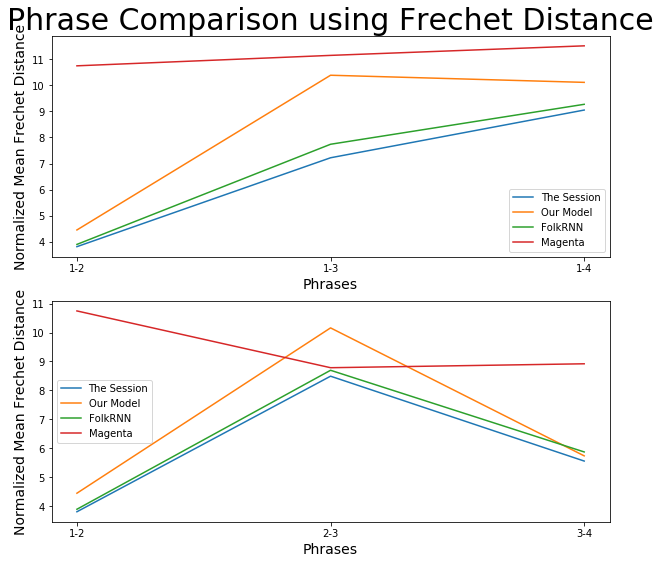

In [0]:
fig = plt.figure(figsize=FIG_SIZE) # Creates a new figure
f1 = fig.add_subplot(211)# add a subplot to the new figure, 111 means "1x1 grid, first subplot"
f2 = fig.add_subplot(212)
fig.subplots_adjust(top=0.80) # adjust the placing of subplot, adjust top, bottom, left and right spacing
f1.set_title(title, fontsize= TITLE_FONT_SIZE) # title of plot
f1.set_xlabel(xlabel,fontsize = FONT_SIZE) #xlabel
f1.set_ylabel(ylabel, fontsize = FONT_SIZE)#ylabel
f2.set_xlabel(xlabel,fontsize = FONT_SIZE) #xlabel
f2.set_ylabel(ylabel, fontsize = FONT_SIZE)#ylabel
f1.plot([real_frechet_mean[0], real_frechet_mean[1], real_frechet_mean[2]], label="The Session")
f1.plot([gen_frechet_mean[0], gen_frechet_mean[1], gen_frechet_mean[2]], label="Our Model")
f1.plot([folk_frechet_mean[0], folk_frechet_mean[1], folk_frechet_mean[2]], label="FolkRNN")
f1.plot([mag_frechet_mean[0], mag_frechet_mean[1], mag_frechet_mean[2]], label="Magenta")

f1.set_xticks(np.arange(3))
f1.set_xticklabels(('1-2', '1-3', '1-4'), minor=False)
f1.legend()
f2.plot([real_frechet_mean[0], real_frechet_mean[3], real_frechet_mean[5]], label="The Session")
f2.plot([gen_frechet_mean[0], gen_frechet_mean[3], gen_frechet_mean[5]], label="Our Model")
f2.plot([folk_frechet_mean[0], folk_frechet_mean[3], folk_frechet_mean[5]], label="FolkRNN")
f2.plot([mag_frechet_mean[0], mag_frechet_mean[3], mag_frechet_mean[5]], label="Magenta")

f2.set_xticks(np.arange(3))
f2.set_xticklabels(('1-2', '2-3', '3-4'))
f2.legend()
plt.show()

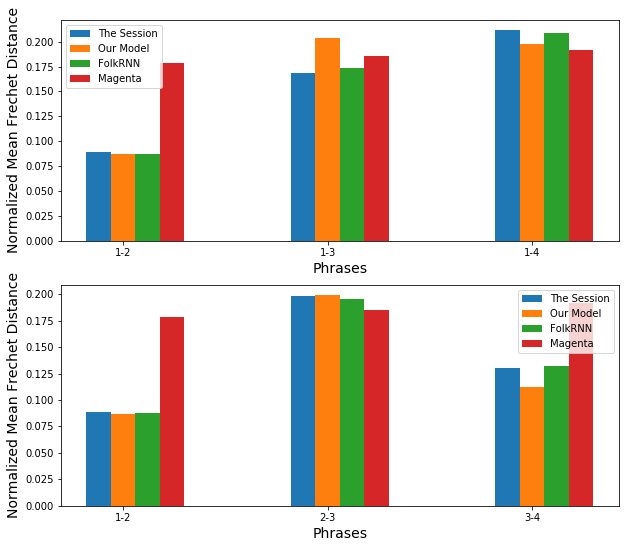

In [0]:
fig = plt.figure(figsize=FIG_SIZE) # Creates a new figure
f1 = fig.add_subplot(211)# add a subplot to the new figure, 111 means "1x1 grid, first subplot"
f2 = fig.add_subplot(212)
fig.subplots_adjust(top=0.80) # adjust the placing of subplot, adjust top, bottom, left and right spacing
#f1.set_title("Normalized Phrase Comparison", fontsize= TITLE_FONT_SIZE) # title of plot

labels_1 = ['(1,2)', '(1,3)', '(1,4)']
x = np.arange(len(labels_1))  # the label locations
ind = np.arange(3)
width = 0.12  # the width of the bars

f1.set_xlabel(xlabel,fontsize = FONT_SIZE) #xlabel
f1.set_ylabel(ylabel, fontsize = FONT_SIZE)#ylabel
f2.set_xlabel(xlabel,fontsize = FONT_SIZE) #xlabel
f2.set_ylabel(ylabel, fontsize = FONT_SIZE)#ylabel


f1.bar(x, [real_frechet_norm[0], real_frechet_norm[1], real_frechet_norm[2]], width,  label="The Session" )
f1.bar(x+width,[gen_frechet_norm[0], gen_frechet_norm[1], gen_frechet_norm[2]], width, label="Our Model", )
f1.bar(x+2*width, [folk_frechet_norm[0], folk_frechet_norm[1], folk_frechet_norm[2]], width,  label="FolkRNN")
f1.bar(x+3*width, [mag_frechet_norm[0], mag_frechet_norm[1], mag_frechet_norm[2]], width,  label="Magenta")


f1.set_xticks(np.arange(3) + width)
f1.set_xticklabels(('1-2', '1-3', '1-4'), minor=False)
f1.legend()

f2.bar(x, [real_frechet_norm[0], real_frechet_norm[3], real_frechet_norm[5]], width,  label="The Session" )
f2.bar(x+width,[gen_frechet_norm[0], gen_frechet_norm[3], gen_frechet_norm[5]], width, label="Our Model", )
f2.bar(x+2*width, [folk_frechet_norm[0], folk_frechet_norm[3], folk_frechet_norm[5]], width,  label="FolkRNN")
f2.bar(x+3*width, [mag_frechet_norm[0], mag_frechet_norm[1], mag_frechet_norm[2]], width,  label="Magenta")

f2.set_xticks(np.arange(3)+width)
f2.set_xticklabels(('1-2', '2-3', '3-4'))
f2.legend()
plt.show()


plt.show()

# **Note Frequency**

In [0]:
flatdata = np.array(data).reshape([820, 256])
flatgen = np.array(tunes_generated).reshape([820,256])
flatfolk = np.array(folkrnn).reshape([811,256])
flatmag = np.array(magenta_generated).reshape([820,256])

In [0]:
datavals, datacount = np.unique(flatdata, return_counts=True)
genvals, gencount = np.unique(flatgen, return_counts=True)
folkvals, folkcount = np.unique(folkrnn, return_counts=True)
magvals, magcount = np.unique(magenta_generated, return_counts=True)

datacount = datacount/np.sum(datacount)
gencount = gencount/np.sum(gencount)
folkcount = folkcount/np.sum(folkcount)
magcount = magcount/np.sum(magcount)


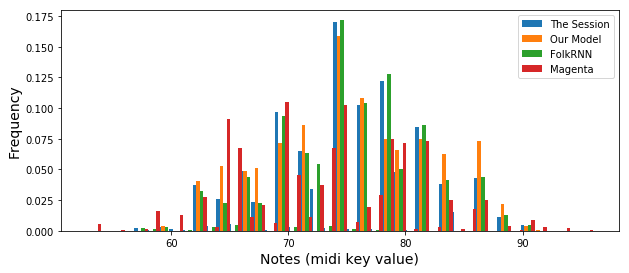

In [0]:
fig = plt.figure(figsize=FIG_SIZE) # Creates a new figure
f1 = fig.add_subplot(211)# add a subplot to the new figure, 111 means "1x1 grid, first subplot"
fig.subplots_adjust(top=0.80) # adjust the placing of subplot, adjust top, bottom, left and right spacing
width = 0.3

f1.set_xlabel("Notes (midi key value)",fontsize = FONT_SIZE) #xlabel
f1.set_ylabel("Frequency", fontsize = FONT_SIZE)#ylabel

f1.bar(datavals, datacount, width, label="The Session")
f1.bar(genvals+width, gencount, width, label="Our Model")
f1.bar(folkvals+width+width, folkcount, width, label="FolkRNN")
f1.bar(magvals+width+width+width, magcount, width, label="Magenta")


f1.legend()
plt.show()

# **Note Accuracy**

In [0]:
noise = np.random.normal(0, 1, [1000, 100])
samples = gen.predict(noise)
samples = np.squeeze(samples,-1)
halfMaxPitch = (NOTE_MAX+NOTE_MIN)//2
pitchRange = NOTE_MAX - halfMaxPitch
# print(samples[0][0])
unrounded = (samples * pitchRange) + halfMaxPitch
# tunes_generated = np.rint(unrounded).astype(np.int)

#Round output values to available values in D major
def samples_to_d_major(samples):
  
  def note_to_d_major(note):
    d_maj_values = np.array([62, 64, 66, 67, 69, 71, 73]) - 60 #C is now at 0
                            # D   E   F   G   A   B   C
    octave = note // 12
    noteInScale = note % 12

    noteDistances = np.abs(d_maj_values - noteInScale)
    roundedNote = d_maj_values[noteDistances.argmin()]
    return roundedNote + 12*octave
    
  note_to_d_major = np.vectorize(note_to_d_major)
  return note_to_d_major(samples).astype(np.int32)

rounded = samples_to_d_major(unrounded)


NameError: ignored

In [0]:
distance = unrounded - rounded
distance = distance.reshape(256000)
heights, bins = np.histogram(distance, 200)
heights = np.array([i/np.sum(heights) for i in heights])
plt.bar(bins[:-1], heights, width = bins[1]-bins[0])
plt.title("Rounding to nearest note")
plt.show()

NameError: ignored

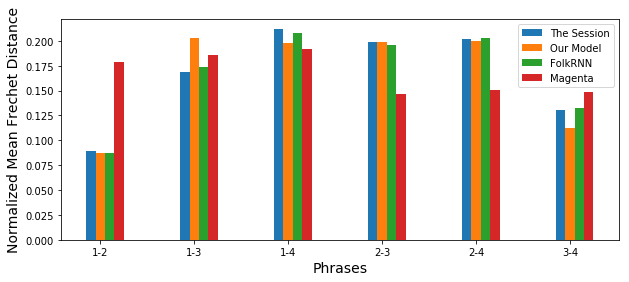

In [0]:
fig = plt.figure(figsize=FIG_SIZE) # Creates a new figure
f1 = fig.add_subplot(211)# add a subplot to the new figure, 111 means "1x1 grid, first subplot"
fig.subplots_adjust(top=0.80) # adjust the placing of subplot, adjust top, bottom, left and right spacing
#f1.set_title("Normalized Phrase Comparison", fontsize= TITLE_FONT_SIZE) # title of plot

labels_1 = ['(1,2)', '(1,3)', '(1,4)', '(2,3)', '(2,4)', '(3,4)']
x = np.arange(len(labels_1))  # the label locations
ind = np.arange(6)
width = 0.1  # the width of the bars

f1.set_xlabel(xlabel,fontsize = FONT_SIZE) #xlabel
f1.set_ylabel(ylabel, fontsize = FONT_SIZE)#ylabel


f1.bar(x, real_frechet_norm, width,  label="The Session" )
f1.bar(x+width,gen_frechet_norm, width, label="Our Model", )
f1.bar(x+2*width, folk_frechet_norm, width,  label="FolkRNN")
f1.bar(x+3*width, mag_frechet_norm, width,  label="Magenta")


f1.set_xticks(np.arange(6) + width)
f1.set_xticklabels(('1-2', '1-3', '1-4', '2-3', '2-4', '3-4'), minor=False)
f1.legend()

plt.show()